In [1]:
import string
import json
import re
import pandas as pd
import numpy as np
import math
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
loans = pd.read_csv('Week_5/lending-club-data.csv')
with open('Week_5/module-8-assignment-2-test-idx.json') as f:
    test_idx = json.load(f)
with open('Week_5/module-8-assignment-2-train-idx.json') as f:
    train_idx = json.load(f)
    




In [ ]:
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.drop('bad_loans', axis='columns')

In [ ]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies
             'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

In [ ]:
loans = loans[[target] + features]
prev = len(loans)
loans = loans.dropna(axis=0, how='any')
now = len(loans)
# Count the number of rows with missing data

print ('Dropping %s observations; keeping %s ' % (prev - now, now))

In [ ]:
loans

In [ ]:
dummy_target = [col for col, datatype in zip(loans.columns, loans.dtypes) if datatype == object]
dummy_target

In [ ]:
loans = pd.get_dummies(loans, columns=dummy_target)
loans.head(5)

In [ ]:
train_data = loans.iloc[train_idx]
validation_data = loans.iloc[validation_idx]
train_data_X = train_data.drop(['safe_loans'], axis='columns')
validation_data_X = validation_data.drop(['safe_loans'], axis='columns')
train_data_Y = train_data['safe_loans']
validation_data_Y = validation_data['safe_loans']

In [ ]:
model_5 = GradientBoostingClassifier(max_depth = 6, n_estimators = 5)
model_5.fit(train_data_X, train_data_Y)

In [ ]:
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

In [ ]:
prediction_sample = model_5.predict(sample_validation_data.drop([target], axis = 'columns'))
num_err_samples = np.array(prediction_sample ==  sample_validation_data[target].values).sum()
print(f'percentage of accuracy is {num_err_samples/float(len(sample_validation_data))}')

In [ ]:
model_5.classes_

In [ ]:
probability_sample = model_5.predict_proba(sample_validation_data.drop([target], axis = 'columns'))
print(probability_sample[:,1])
positive_prob = np.array(probability_sample[:,1])
print(f'The sample with highest probability is {np.argmax(positive_prob)} of {max(positive_prob)}')

In [ ]:
score_valid = model_5.score(validation_data_X, validation_data_Y)
print(score_valid)

In [ ]:
#false positive
predictions = model_5.predict(train_data_X)
false_positive = np.asarray(((predictions==1) * (train_data_Y==-1)), dtype=int).sum()
print (false_positive)

In [ ]:

# Calculate the number of negatives made by the model.
predictions = model_5.predict(train_data_X)
false_negative = np.asarray(((predictions==-1) * (train_data_Y==1)),dtype=int).sum()
print (false_negative)

In [ ]:

# Calculate the number of false negatives on the validation_data
predictions = model_5.predict(validation_data_X)
false_negative = np.asarray(((predictions==-1) * (validation_data_Y==1)),dtype=int).sum()
print (false_negative)

In [ ]:
#What is the number of false positives on the validation_data?
predictions = model_5.predict(validation_data_X)
false_positive = np.asarray(((predictions==1) * (validation_data_Y==-1)),dtype=int).sum()
print (false_positive)

In [ ]:

print ("Cost: ",(10000 * false_negative) + (20000 * false_positive))

In [ ]:
validation_data['predictions'] = [x[1] for x in model_5.predict_proba(validation_data_X)]
top_5 = validation_data.sort_values(by = "predictions", ascending=False)[:5]
top_5[['grade_A','grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G']]

In [ ]:
low_5 = validation_data.sort_values(by = "predictions", ascending=True)[:5]
low_5[['grade_A','grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G']]

In [ ]:
model_10 = GradientBoostingClassifier(n_estimators=10, max_depth=6, verbose=False).fit(train_data_X, train_data_Y)
model_50 = GradientBoostingClassifier(n_estimators=50, max_depth=6, verbose=False).fit(train_data_X, train_data_Y)
model_100 = GradientBoostingClassifier(n_estimators=100, max_depth=6, verbose=False).fit(train_data_X, train_data_Y)
model_200 = GradientBoostingClassifier(n_estimators=200, max_depth=6, verbose=False).fit(train_data_X, train_data_Y)
model_500 = GradientBoostingClassifier(n_estimators=500, max_depth=6, verbose=False).fit(train_data_X, train_data_Y)

print ("Model-10 Accuracy: ",model_10.score(validation_data_X,validation_data_Y))
print ("Model-50 Accuracy: ",model_50.score(validation_data_X,validation_data_Y))
print ("Model-100 Accuracy: ",model_100.score(validation_data_X,validation_data_Y))
print ("Model-200 Accuracy: ",model_200.score(validation_data_X,validation_data_Y))
print ("Model-500 Accuracy: ",model_500.score(validation_data_X,validation_data_Y))

In [ ]:
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In [ ]:

#error= 1-accuracy
train_err_10 = 1-model_10.score(train_data_X,train_data_Y)
train_err_50 = 1-model_50.score(train_data_X,train_data_Y)
train_err_100 = 1-model_100.score(train_data_X,train_data_Y)
train_err_200 = 1-model_200.score(train_data_X,train_data_Y)
train_err_500 = 1-model_500.score(train_data_X,train_data_Y)

training_errors = [train_err_10, train_err_50, train_err_100, 
                   train_err_200, train_err_500]

validation_err_10 = 1-model_10.score(validation_data_X,validation_data_Y)
validation_err_50 = 1-model_50.score(validation_data_X,validation_data_Y)
validation_err_100 = 1-model_100.score(validation_data_X,validation_data_Y)
validation_err_200 = 1-model_200.score(validation_data_X,validation_data_Y)
validation_err_500 = 1-model_500.score(validation_data_X,validation_data_Y)

validation_errors = [validation_err_10, validation_err_50, validation_err_100, 
                     validation_err_200, validation_err_500]

In [ ]:
plt.plot([10, 50, 100, 200, 500], training_errors, linewidth=4.0, label='Training error')
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')

In [ ]:
## part 2

In [7]:
features = ['grade',              # grade of the loan
            'term',               # the term of the loan
            'home_ownership',     # home ownership status: own, mortgage or rent
            'emp_length',         # number of years of employment
           ]
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans.drop('bad_loans', axis = 'columns')
target = 'safe_loans'
loans = loans[features + [target]]

In [4]:
loans

,grade,term,home_ownership,emp_length,safe_loans
0,B,36 months,RENT,10+ years,1
1,C,60 months,RENT,< 1 year,-1
2,C,36 months,RENT,10+ years,1
3,C,36 months,RENT,10+ years,1
4,A,36 months,RENT,3 years,1
...,...,...,...,...,...
122602,E,60 months,MORTGAGE,NaN,-1
122603,D,36 months,MORTGAGE,10+ years,1
122604,D,60 months,MORTGAGE,5 years,-1
122605,D,60 months,MORTGAGE,10+ years,-1


In [11]:
train_data = loans.iloc[train_idx]
test_data = loans.iloc[test_idx]


In [12]:
##dropping rows with NaN values
prev_train = len(train_data)
train_data = train_data.dropna(axis=0, how='any')
now_train = len(train_data)
# Count the number of rows with missing data

print ('Dropping %s observations from train data; keeping %s ' % (prev_train - now_train, now_train))

prev_test = len(test_data)
test_data = test_data.dropna(axis=0, how='any')
now_test = len(test_data)
# Count the number of rows with missing data

print ('Dropping %s observations from test data; keeping %s ' % (prev_test - now_test, now_test))

Dropping 1443 observations from train data; keeping 35781 
Dropping 349 observations from test data; keeping 8935 


In [14]:
dummy_target = [col for col, datatype in zip(train_data.columns, train_data.dtypes) if datatype == object]
train_data = pd.get_dummies(train_data, columns=dummy_target)
train_data.head(5)

,safe_loans,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,term_ 36 months,term_ 60 months,...,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year
1,-1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
6,-1,0,0,0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
7,-1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
10,-1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
12,-1,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [15]:
dummy_target = [col for col, datatype in zip(test_data.columns, test_data.dtypes) if datatype == object]
test_data = pd.get_dummies(test_data, columns=dummy_target)
test_data.head(5)

,safe_loans,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,term_ 36 months,term_ 60 months,...,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year
24,-1,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
41,-1,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
60,-1,0,0,0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
93,-1,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
132,-1,0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0


In [16]:
train_data_X = train_data.drop(['safe_loans'], axis='columns')
test_data_X = test_data.drop(['safe_loans'], axis='columns')
train_data_Y = train_data['safe_loans']
test_data_Y = test_data['safe_loans']

In [33]:
def intermediate_node_weighted_mistakes(labels_in_node, data_weights):
    # Sum the weights of all entries with label +1
    total_weight_positive = sum(data_weights[labels_in_node == +1])
    
    # Weight of mistakes for predicting all -1's is equal to the sum above
    ### YOUR CODE HERE
    weighted_mistakes_all_negative = total_weight_positive
    
    # Sum the weights of all entries with label -1
    ### YOUR CODE HERE
    total_weight_negative = sum(data_weights[labels_in_node == -1])
    
    # Weight of mistakes for predicting all +1's is equal to the sum above
    ### YOUR CODE HERE
    weighted_mistakes_all_positive = total_weight_negative
    
    # Return the tuple (weight, class_label) representing the lower of the two weights
    #    class_label should be an integer of value +1 or -1.
    # If the two weights are identical, return (weighted_mistakes_all_positive,+1)
    ### YOUR CODE HERE
    if  weighted_mistakes_all_negative >= weighted_mistakes_all_positive:
        return (weighted_mistakes_all_positive,+1)
    else:
        return (weighted_mistakes_all_negative,-1)

In [35]:

#Checkpoint: Test your intermediate_node_weighted_mistakes function, run the following cell:
example_labels = np.asarray([-1, -1, 1, 1, 1])
example_data_weights = np.asarray([1., 2., .5, 1., 1.])
if intermediate_node_weighted_mistakes(example_labels, example_data_weights) == (2.5, -1):
    print ('Test passed!')
else:
    print ('Test failed... try again!')

Test passed!


In [18]:
# If the data is identical in each feature, this function should return None

def best_splitting_feature(data, features, target, data_weights):
    
    # These variables will keep track of the best feature and the corresponding error
    best_feature = None
    best_error = float('+inf') 
    num_points = float(len(data))
    
    # Loop through each feature to consider splitting on that feature
    for feature in features:
        
        # The left split will have all data points where the feature value is 0
        # The right split will have all data points where the feature value is 1
        left_split = data[data[feature] == 0]
        right_split = data[data[feature] == 1]
        
        # Apply the same filtering to data_weights to create left_data_weights, right_data_weights
        ## YOUR CODE HERE
        left_data_weights = data_weights[data[feature] == 0]
        right_data_weights = data_weights[data[feature] == 1]
                    
        # DIFFERENT HERE
        # Calculate the weight of mistakes for left and right sides
        ## YOUR CODE HERE
        left_weighted_mistakes, left_class = intermediate_node_weighted_mistakes(left_split[target], left_data_weights)
        right_weighted_mistakes, right_class = intermediate_node_weighted_mistakes(right_split[target], right_data_weights)
        
        # DIFFERENT HERE
        # Compute weighted error by computing
        #  ( [weight of mistakes (left)] + [weight of mistakes (right)] ) / [total weight of all data points]
        ## YOUR CODE HERE
        error = (left_weighted_mistakes + right_weighted_mistakes)/float(sum(data_weights))
        
        # If this is the best error we have found so far, store the feature and the error
        if error < best_error:
            best_feature = feature
            best_error = error
    
    # Return the best feature we found
    return best_feature

In [53]:

example_data_weights = np.asarray(len(train_data)* [1.5])
fe = best_splitting_feature(train_data, my_new_feature, target, example_data_weights)
assert fe == 'term_ 36 months', 'test failed!'


In [19]:
def create_leaf(target_values, data_weights):
    
    # Create a leaf node
    leaf = {'splitting_feature' : None,
            'is_leaf': True}
    
    # Computed weight of mistakes.
    # Store the predicted class (1 or -1) in leaf['prediction']
    weighted_error, best_class = intermediate_node_weighted_mistakes(target_values, data_weights)
    leaf['prediction'] = best_class
    
    return leaf

In [20]:
def weighted_decision_tree_create(data, features, target, data_weights, current_depth = 1, max_depth = 10):
    remaining_features = features[:] # Make a copy of the features.
    target_values = data[target]
    print ("--------------------------------------------------------------------")
    print ("Subtree, depth = %s (%s data points)." % (current_depth, len(target_values)))
    
    # Stopping condition 1. Error is 0.
    if intermediate_node_weighted_mistakes(target_values, data_weights)[0] <= 1e-15:
        print ("Stopping condition 1 reached.")                
        return create_leaf(target_values, data_weights)
    
    # Stopping condition 2. No more features.
    if remaining_features == []:
        print ("Stopping condition 2 reached.")                
        return create_leaf(target_values, data_weights)    
    
    # Additional stopping condition (limit tree depth)
    if current_depth > max_depth:
        print ("Reached maximum depth. Stopping for now.")
        return create_leaf(target_values, data_weights)
    
    # If all the datapoints are the same, splitting_feature will be None. Create a leaf
    splitting_feature = best_splitting_feature(data, features, target, data_weights)
    remaining_features.remove(splitting_feature)
        
    left_split = data[data[splitting_feature] == 0]
    right_split = data[data[splitting_feature] == 1]
    
    left_data_weights = data_weights[data[splitting_feature] == 0]
    right_data_weights = data_weights[data[splitting_feature] == 1]
    
    print ("Split on feature %s. (%s, %s)" % (splitting_feature, len(left_split), len(right_split)))
    
    # Create a leaf node if the split is "perfect"
    if len(left_split) == len(data):
        print ("Creating leaf node.")
        return create_leaf(left_split[target], data_weights)
    if len(right_split) == len(data):
        print ("Creating leaf node.")
        return create_leaf(right_split[target], data_weights)
    
    # Repeat (recurse) on left and right subtrees
    left_tree = weighted_decision_tree_create(
        left_split, remaining_features, target, left_data_weights, current_depth + 1, max_depth)
    right_tree = weighted_decision_tree_create(
        right_split, remaining_features, target, right_data_weights, current_depth + 1, max_depth)
    
    return {'is_leaf'          : False, 
            'prediction'       : None,
            'splitting_feature': splitting_feature,
            'left'             : left_tree, 
            'right'            : right_tree}

In [21]:
def count_nodes(tree):
    if tree['is_leaf']:
        return 1
    return 1 + count_nodes(tree['left']) + count_nodes(tree['right'])

In [58]:
#Making predictions with a weighted decision tree
def classify(tree, x, annotate = False):   
    # If the node is a leaf node.
    if tree['is_leaf']:
        if annotate: 
            print ("At leaf, predicting %s" % tree['prediction'])
        return tree['prediction'] 
    else:
        # Split on feature.
        split_feature_value = x[tree['splitting_feature']]
        if annotate: 
            print ("Split on %s = %s" % (tree['splitting_feature'], split_feature_value))
        if split_feature_value == 0:
            return classify(tree['left'], x, annotate)
        else:
            return classify(tree['right'], x, annotate)

In [80]:
def evaluate_classification_error(tree, data):
    # Apply the classify(tree, x) to each row in your data
    prediction = data.apply(lambda x: classify(tree, x), axis = 1)
    
    # Once you've made the predictions, calculate the classification error
    return (prediction != data[target]).sum() / float(len(data))

In [50]:
my_new_feature = list(train_data.columns)
my_new_feature.remove(target)
print(my_new_feature)

['grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G', 'term_ 36 months', 'term_ 60 months', 'home_ownership_MORTGAGE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'emp_length_1 year', 'emp_length_10+ years', 'emp_length_2 years', 'emp_length_3 years', 'emp_length_4 years', 'emp_length_5 years', 'emp_length_6 years', 'emp_length_7 years', 'emp_length_8 years', 'emp_length_9 years', 'emp_length_< 1 year']


In [54]:
# test code 
example_data_weights = np.asarray([1.0 for i in range(len(train_data))])
small_data_decision_tree = weighted_decision_tree_create(train_data, my_new_feature, target, example_data_weights, max_depth=2)
assert count_nodes(small_data_decision_tree) == 7, 'test failed!'


--------------------------------------------------------------------
Subtree, depth = 1 (35781 data points).
Split on feature term_ 36 months. (8997, 26784)
--------------------------------------------------------------------
Subtree, depth = 2 (8997 data points).
Split on feature grade_A. (8901, 96)
--------------------------------------------------------------------
Subtree, depth = 3 (8901 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (96 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (26784 data points).
Split on feature grade_D. (22290, 4494)
--------------------------------------------------------------------
Subtree, depth = 3 (22290 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (4494 data poin

In [56]:
# Assign weights
example_data_weights = np.array([1.] * 10 + [0.]*(len(train_data) - 20) + [1.] * 10)
# Train a weighted decision tree model.
small_data_decision_tree_subset_20 = weighted_decision_tree_create(train_data, my_new_feature, target,
                         example_data_weights, max_depth=2)

--------------------------------------------------------------------
Subtree, depth = 1 (35781 data points).
Split on feature home_ownership_RENT. (19645, 16136)
--------------------------------------------------------------------
Subtree, depth = 2 (19645 data points).
Split on feature grade_F. (18768, 877)
--------------------------------------------------------------------
Subtree, depth = 3 (18768 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (877 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 2 (16136 data points).
Split on feature grade_D. (12857, 3279)
--------------------------------------------------------------------
Subtree, depth = 3 (12857 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 3 (3279 data points).
Stoppin

In [62]:
small_data_decision_tree_subset_20

{'is_leaf': False,
 'prediction': None,
 'splitting_feature': 'home_ownership_RENT',
 'left': {'is_leaf': False,
  'prediction': None,
  'splitting_feature': 'grade_F',
  'left': {'splitting_feature': None, 'is_leaf': True, 'prediction': 1},
  'right': {'splitting_feature': None, 'is_leaf': True, 'prediction': -1}},
 'right': {'is_leaf': False,
  'prediction': None,
  'splitting_feature': 'grade_D',
  'left': {'splitting_feature': None, 'is_leaf': True, 'prediction': -1},
  'right': {'splitting_feature': None, 'is_leaf': True, 'prediction': 1}}}

In [67]:
train_data.columns
    

Index(['safe_loans', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E',
       'grade_F', 'grade_G', 'term_ 36 months', 'term_ 60 months',
       'home_ownership_MORTGAGE', 'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT', 'emp_length_1 year', 'emp_length_10+ years',
       'emp_length_2 years', 'emp_length_3 years', 'emp_length_4 years',
       'emp_length_5 years', 'emp_length_6 years', 'emp_length_7 years',
       'emp_length_8 years', 'emp_length_9 years', 'emp_length_< 1 year'],
      dtype='object')

In [72]:
evaluate_classification_error(small_data_decision_tree_subset_20, train_data)

0.4800033537352226

In [73]:
evaluate_classification_error(small_data_decision_tree, test_data)

0.3948517067711248

In [81]:
from math import log
from math import exp

def adaboost_with_tree_stumps(data, features, target, num_tree_stumps):
    # start with unweighted data
    alpha = np.array(([1.]*len(data)))
    weights = []
    tree_stumps = []
    target_values = data[target]
    
    for t in range(num_tree_stumps):
        print ('=====================================================')
        print ('Adaboost Iteration %d' % t)
        print ('=====================================================')        
        # Learn a weighted decision tree stump. Use max_depth=1
        tree_stump = weighted_decision_tree_create(data, features, target, data_weights=alpha, max_depth=1)
        tree_stumps.append(tree_stump)
        
        # Make predictions
        predictions = data.apply(lambda x: classify(tree_stump, x), axis = 1)
        
        # Produce a Boolean array indicating whether
        # each data point was correctly classified
        is_correct = predictions == target_values
        is_wrong   = predictions != target_values
        
        # Compute weighted error
        # YOUR CODE HERE
        weighted_error = np.sum(np.multiply(np.array(is_wrong), alpha)) * (1. / np.sum(alpha))
        
        # Compute model coefficient using weighted error
        # YOUR CODE HERE
        weight =  (1. / 2) * log((1 - weighted_error) * (1. / (weighted_error)))
        weights.append(weight)
        
        # Adjust weights on data point
        adjustment = is_correct.apply(lambda is_correct : exp(-weight) if is_correct else exp(weight))
        
        # Scale alpha by multiplying by adjustment
        # Then normalize data points weights
        ## YOUR CODE HERE 
        alpha = alpha * np.array(adjustment)
        alpha = alpha / np.sum(alpha)
    
    return weights, tree_stumps

In [82]:

# Checking your Adaboost code
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, my_new_feature, target, num_tree_stumps=2)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (35781 data points).
Split on feature term_ 36 months. (8997, 26784)
--------------------------------------------------------------------
Subtree, depth = 2 (8997 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (26784 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (35781 data points).
Split on feature grade_A. (30886, 4895)
--------------------------------------------------------------------
Subtree, depth = 2 (30886 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (4895 data points).
Reached maximum depth. Stopping for now.


In [93]:
def predict_adaboost(stump_weights, tree_stumps, data):
    scores = np.array([0.]*len(data))
    
    for i, tree_stump in enumerate(tree_stumps):
        predictions = data.apply(lambda x: classify(tree_stump, x), axis = 1)
        
        # Accumulate predictions on scores array
        # YOUR CODE HERE
        scores = scores + stump_weights[i] * np.array(predictions)
    scores = pd.Series(scores)
    return scores.apply(lambda score : +1 if score > 0 else -1)

In [94]:
train_data_predictions = predict_adaboost(stump_weights, tree_stumps, train_data)
train_accuracy = np.sum(np.array(train_data[target]) == train_data_predictions) / float(len(train_data_predictions))
print ('training data Accuracy of 10-component ensemble = %s' % train_accuracy)

training data Accuracy of 10-component ensemble = 0.5632039350493279


In [95]:
tree_stumps

[{'is_leaf': False,
  'prediction': None,
  'splitting_feature': 'term_ 36 months',
  'left': {'splitting_feature': None, 'is_leaf': True, 'prediction': -1},
  'right': {'splitting_feature': None, 'is_leaf': True, 'prediction': 1}},
 {'is_leaf': False,
  'prediction': None,
  'splitting_feature': 'grade_A',
  'left': {'splitting_feature': None, 'is_leaf': True, 'prediction': -1},
  'right': {'splitting_feature': None, 'is_leaf': True, 'prediction': 1}}]

In [97]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, 
                                 my_new_feature, target, num_tree_stumps=30)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (35781 data points).
Split on feature term_ 36 months. (8997, 26784)
--------------------------------------------------------------------
Subtree, depth = 2 (8997 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (26784 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (35781 data points).
Split on feature grade_A. (30886, 4895)
--------------------------------------------------------------------
Subtree, depth = 2 (30886 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (4895 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
---------------------------------

Split on feature grade_E. (32475, 3306)
--------------------------------------------------------------------
Subtree, depth = 2 (32475 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (3306 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 15
--------------------------------------------------------------------
Subtree, depth = 1 (35781 data points).
Split on feature grade_A. (30886, 4895)
--------------------------------------------------------------------
Subtree, depth = 2 (30886 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (4895 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 16
--------------------------------------------------------------------
Subtree, depth = 1 (35781 data points).
Split on feature grade_F. (34122, 1659)
--------------------

Adaboost Iteration 29
--------------------------------------------------------------------
Subtree, depth = 1 (35781 data points).
Split on feature grade_G. (35352, 429)
--------------------------------------------------------------------
Subtree, depth = 2 (35352 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (429 data points).
Reached maximum depth. Stopping for now.


In [98]:
error_all = []
for n in range(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], train_data)
    error = np.sum(np.array(train_data[target]) != predictions) / float(len(predictions))
    error_all.append(error)
    print ("Iteration %s, training error = %s" % (n, error_all[n-1]))

Iteration 1, training error = 0.417148766104916
Iteration 2, training error = 0.43679606495067214
Iteration 3, training error = 0.39674687683407395
Iteration 4, training error = 0.39674687683407395
Iteration 5, training error = 0.38327604035661383
Iteration 6, training error = 0.3903188843240826
Iteration 7, training error = 0.38129174701657303
Iteration 8, training error = 0.38788742628769457
Iteration 9, training error = 0.38129174701657303
Iteration 10, training error = 0.3831083535954836
Iteration 11, training error = 0.3799502529275314
Iteration 12, training error = 0.3799502529275314
Iteration 13, training error = 0.3799502529275314
Iteration 14, training error = 0.3799502529275314
Iteration 15, training error = 0.3799502529275314
Iteration 16, training error = 0.3799502529275314
Iteration 17, training error = 0.3799502529275314
Iteration 18, training error = 0.37992230513400965
Iteration 19, training error = 0.37992230513400965
Iteration 20, training error = 0.3801458874821833
I

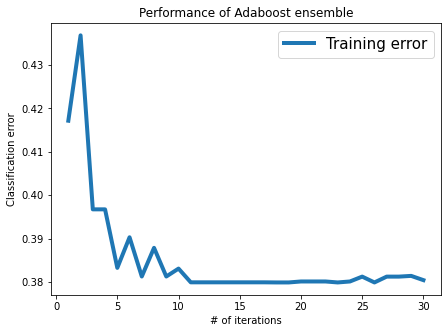

In [99]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.legend(loc='best', prop={'size':15})

plt.rcParams.update({'font.size': 16})

In [101]:
test_error_all = []
for n in range(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], test_data)
    error = np.sum(np.array(test_data[target]) != predictions) / float(len(predictions))
    test_error_all.append(error)
    print ("Iteration %s, test error = %s" % (n, test_error_all[n-1]))

Iteration 1, test error = 0.41891438164521544
Iteration 2, test error = 0.43133743704532734
Iteration 3, test error = 0.3948517067711248
Iteration 4, test error = 0.3948517067711248
Iteration 5, test error = 0.3791829882484611
Iteration 6, test error = 0.3899272523782876
Iteration 7, test error = 0.378735310576385
Iteration 8, test error = 0.3878007834359261
Iteration 9, test error = 0.378735310576385
Iteration 10, test error = 0.3791829882484611
Iteration 11, test error = 0.3773922775601567
Iteration 12, test error = 0.3773922775601567
Iteration 13, test error = 0.3773922775601567
Iteration 14, test error = 0.3773922775601567
Iteration 15, test error = 0.3773922775601567
Iteration 16, test error = 0.3773922775601567
Iteration 17, test error = 0.3773922775601567
Iteration 18, test error = 0.37761611639619475
Iteration 19, test error = 0.37761611639619475
Iteration 20, test error = 0.3772803581421377
Iteration 21, test error = 0.3772803581421377
Iteration 22, test error = 0.377280358142

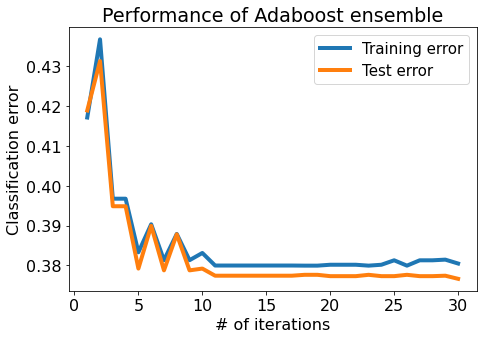

In [102]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.plot(range(1,31), test_error_all, '-', linewidth=4.0, label='Test error')

plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.rcParams.update({'font.size': 16})
plt.legend(loc='best', prop={'size':15})
plt.tight_layout()